### Here begins code from the DC GAN example page from pytorch documentation

imports

In [1]:
from __future__ import print_function
#%matplotlib inline
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

from gan import Generator, Discriminator

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Define data params for data loading and defining network input shapes

In [2]:
# Root directory for dataset
dataroot = "data/"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of GPUs available. Use 0 for CPU mode.
if torch.cuda.is_available():
    print(f'GPU name is: {torch.cuda.get_device_name(0)}')    
    ngpu = 1
else:
    print('Running on CPU')
    ngpu = 0


GPU name is: Tesla T4


Initialise dataloader and look at some of the training images

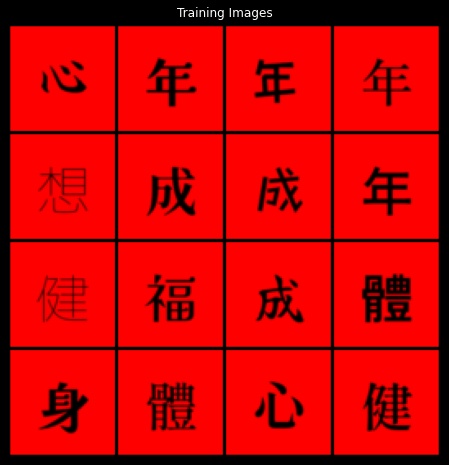

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

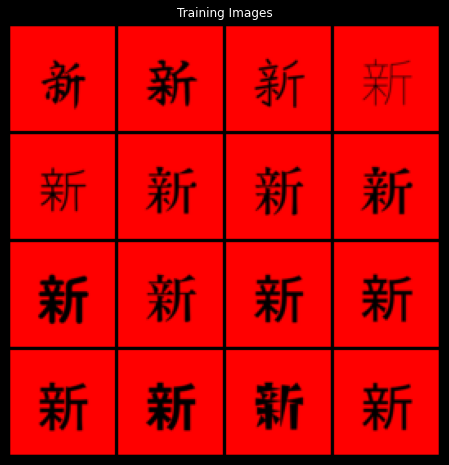

In [4]:
from torch.utils.data import Subset

char='新'
idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] == dataset.class_to_idx[char]]
# build the appropriate subset
subset = Subset(dataset, idx)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

Define & Initialise architecture

In [5]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator
netG = Generator(ngpu, nz, ngf, nc).to(device)
netD = Discriminator(ngpu, ndf, nc).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)
netD.apply(weights_init)

# Print the model
print(f'Generator:\n{netG}')
print(f'Discriminator:\n{netD}')

# LOAD MODELS IF NECESSARY
# load_name = 'models/GAN_iter_0.ckpt'
# checkpoint = torch.load(load_name, map_location=device)
# netG.load_state_dict(checkpoint['netG_state_dict'])
# netD.load_state_dict(checkpoint['netD_state_dict'])
# optimizerG.load_state_dict(checkpoint['optimG_state_dict'])
# optimizerD.load_state_dict(checkpoint['optimD_state_dict'])


Generator:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ta

Train the model

In [6]:
# Training Loop

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 1e-3

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)

        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            torch.save({
                'iters': iters,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optimG_state_dict': optimizerG.state_dict(),
                'optimD_state_dict': optimizerD.state_dict(),
            },f'models/{char}_iter_{iters}.ckpt')            
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            

        iters += 1

Starting Training Loop...
[0/50][0/6]	Loss_D: 1.5229	Loss_G: 31.1346	D(x): 0.7158	D(G(z)): 0.6028 / 0.0000
[1/50][0/6]	Loss_D: 0.0000	Loss_G: 42.6087	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/50][0/6]	Loss_D: 0.0000	Loss_G: 42.2318	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/50][0/6]	Loss_D: 0.0000	Loss_G: 42.5973	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][0/6]	Loss_D: 0.0000	Loss_G: 42.1605	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][0/6]	Loss_D: 0.0000	Loss_G: 42.2546	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/50][0/6]	Loss_D: 0.0000	Loss_G: 42.3085	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[7/50][0/6]	Loss_D: 0.0000	Loss_G: 41.8767	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[8/50][0/6]	Loss_D: 0.0000	Loss_G: 41.8261	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[9/50][0/6]	Loss_D: 0.0000	Loss_G: 41.6027	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[10/50][0/6]	Loss_D: 0.0000	Loss_G: 41.1128	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[11/50][0/6]	Loss_D: 0.0000	Loss_G: 41.1501	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


Plot the loss curves

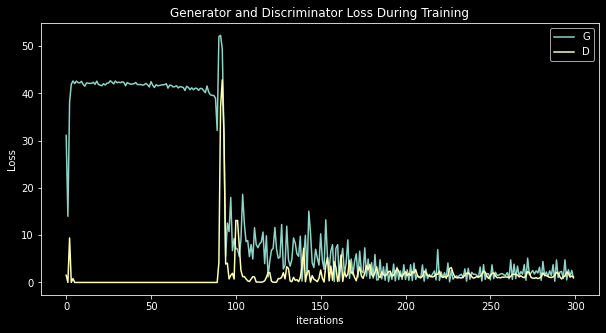

In [7]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Let's look at some examples!

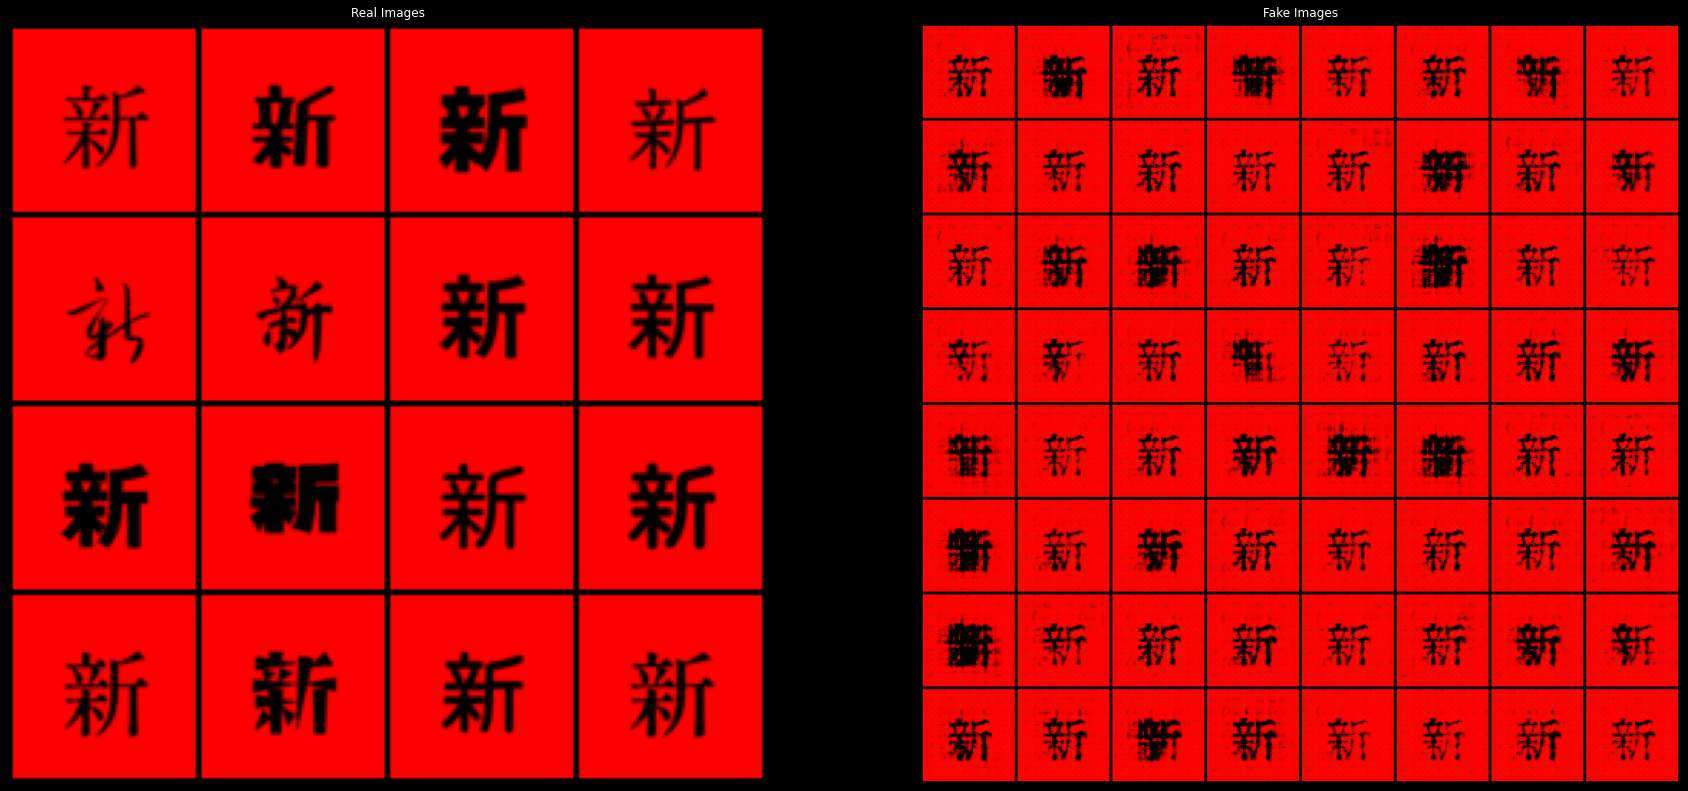

<Figure size 432x288 with 0 Axes>

In [8]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
plt.savefig('real_vs_fake.jpg')